# Telco Cusstomer Churn: Model Building

## Table of Contents 
1. [Model Training](#1-model-training)  
2. [Model Evaluation](#2-model-evaluation) 
3. [Model Export](#2-model-export) 

## 1. Model Training

In [171]:
# --- Warnings ---
import warnings
warnings.filterwarnings("ignore")

# --- Data handling ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Imbalanced data handling ---
from imblearn.combine import SMOTETomek

# --- Machine Learning & Models ---
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# --- Model selection & hyperparameter tuning ---
from sklearn.model_selection import cross_val_score
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress Optuna info logs

# --- Metrics ---
from sklearn.metrics import (
    mean_squared_error,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, make_scorer
)

# --- Model persistence ---
import joblib


In [ ]:
import pandas as pd

# Read the saved datasets
X_train = pd.read_csv("artifacts/feature_engineering/X_train.csv")
X_test  = pd.read_csv("artifacts/feature_engineering/X_test.csv")
y_train = pd.read_csv("artifacts/feature_engineering/y_train.csv")
y_test  = pd.read_csv("artifacts/feature_engineering/y_test.csv")

print(f"X_train= {X_train.shape}, y_train= {y_train.shape}")
print(f"X_test= {X_test.shape}, y_test= {y_test.shape}")

X_train= (5587, 20), y_train= (5587, 1)
X_test= (1397, 20), y_test= (1397, 1)


In [168]:
X_train.head(3)

,City,Contract,is_payment_recurring,Tenure Months,Tech Support,Online Security,Internet Service,Payment Method,Online Backup,Device Protection,Dependents,Streaming TV,Streaming Movies,is_payment_automatic,Monthly Charges,Paperless Billing,additional_services,Senior Citizen,Partner,CLTV
0,0.302354,0.413065,1,0.458333,0.139233,0.399282,0.176836,0.438043,0.209677,0.212866,0,0.287872,0.323001,0,0.315920,1,0.75,1,1,0.799867
1,0.250849,0.028169,0,0.791667,0.403853,0.141593,0.176836,0.154400,0.381595,0.212866,0,0.287872,0.288183,1,0.558209,1,0.50,0,0,0.788303
2,0.254207,0.099914,0,0.666667,0.403853,0.399282,0.408549,0.438043,0.209677,0.378411,0,0.287872,0.288183,0,0.803483,1,0.25,1,0,0.235268


### 1.1 Resampling using SMOTETomek

In [ ]:
# Apply SMOTE-Tomek on training data only
smote_tomek = SMOTETomek(random_state=42, sampling_strategy="auto")
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print("Before SMOTE-Tomek:", y_train.value_counts().to_dict())
print("After SMOTE-Tomek:", y_train_resampled.value_counts().to_dict())

Before SMOTE-Tomek: {(0,): 4162, (1,): 1425}
After SMOTE-Tomek: {(0,): 4040, (1,): 4040}


### 1.2 Hyper Parameter Tuning with Optuna

### 1.2.1 Logistic Regression

In [ ]:
def objective_lr(trial):
    model = LogisticRegression(
        C = trial.suggest_float('C', 1e-4, 1e4, log=True),
        solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'newton-cg']),
        tol = trial.suggest_float('tol', 1e-6, 1e-1, log=True),
        class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    )
    
    scorer = make_scorer(recall_score, average='binary', pos_label=1)
    return cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring=scorer, n_jobs=-1).mean()

# Progress bar setup
total_trials = 100
pbar = tqdm(total=total_trials, desc="Optuna Trials", unit="trial")

def progress_callback(study, trial):
    pbar.update(1)

study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_lr, n_trials=total_trials, callbacks=[progress_callback])

pbar.close()

print("model: Logistic Regression", "\nscore: ", study_lr.best_trial.value, "\nparams: ", study_lr.best_trial.params)

Optuna Trials: 100%|██████████| 100/100 [00:06<00:00, 14.51trial/s]

model: Logistic Regression 
score:  0.9141089108910891 
params:  {'C': 0.00010050911089731326, 'solver': 'liblinear', 'tol': 0.0008585753270861602, 'class_weight': None}


#### 1.2.2 Random Forest

In [ ]:
def objective_rf(trial):
    model = RandomForestClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100, 300),
        max_depth = trial.suggest_int("max_depth", 5, 30),
        min_samples_split = trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5),
        random_state = 42,
        n_jobs = -1
    )
    scorer = make_scorer(recall_score, average='binary', pos_label=1)
    return cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring=scorer, n_jobs=-1).mean()

# Progress bar setup
total_trials = 100
pbar = tqdm(total=total_trials, desc="Optuna Trials", unit="trial")

def progress_callback(study, trial):
    pbar.update(1)

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=total_trials, callbacks=[progress_callback])

pbar.close()

print("model: Random Forest", "\nscore: ", study_rf.best_trial.value, "\nparams: ", study_rf.best_trial.params)

Optuna Trials: 100%|██████████| 100/100 [01:48<00:00,  1.08s/trial]

model: Random Forest 
score:  0.9136138613861385 
params:  {'n_estimators': 160, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}


#### 1.2.3 KNN

In [ ]:
def objective_knn(trial):
    model = KNeighborsClassifier(
        n_neighbors = trial.suggest_int("n_neighbors", 3, 15),
        weights = trial.suggest_categorical("weights", ["uniform", "distance"]),
        metric = trial.suggest_categorical("metric", ["euclidean", "manhattan"])
    )
    scorer = make_scorer(recall_score, average='binary', pos_label=1)
    return cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring=scorer, n_jobs=-1).mean()

# Progress bar setup
total_trials = 100
pbar = tqdm(total=total_trials, desc="Optuna Trials", unit="trial")

def progress_callback(study, trial):
    pbar.update(1)

study_knn = optuna.create_study(direction="maximize")
study_knn.optimize(objective_knn, n_trials=total_trials, callbacks=[progress_callback])

pbar.close()

print("model: KNN", "\nscore: ", study_knn.best_trial.value, "\nparams: ", study_knn.best_trial.params)

Optuna Trials: 100%|██████████| 100/100 [00:12<00:00,  8.02trial/s]

model: KNN 
score:  0.9683168316831683 
params:  {'n_neighbors': 3, 'weights': 'distance', 'metric': 'euclidean'}


#### 1.2.4 XGBoost

In [ ]:
def objective_xgb(trial):
    model = XGBClassifier(
        n_estimators = trial.suggest_int("n_estimators", 100, 300),
        max_depth = trial.suggest_int("max_depth", 3, 10),
        learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        subsample = trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.6, 1.0),
        gamma = trial.suggest_float("gamma", 0, 5),
        reg_alpha = trial.suggest_float("reg_alpha", 1e-4, 10, log=True),
        reg_lambda = trial.suggest_float("reg_lambda", 1e-4, 10, log=True),
        use_label_encoder = False,
        eval_metric = 'logloss',
        random_state = 42,
        n_jobs = -1
    )
    scorer = make_scorer(recall_score, average='binary', pos_label=1)
    return cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring=scorer, n_jobs=-1).mean()

# Progress bar setup
total_trials = 100
pbar = tqdm(total=total_trials, desc="Optuna Trials", unit="trial")

def progress_callback(study, trial):
    pbar.update(1)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=total_trials, callbacks=[progress_callback])

pbar.close()

print("model: XGBoost", "\nscore: ", study_xgb.best_trial.value, "\nparams: ", study_xgb.best_trial.params)

Optuna Trials: 100%|██████████| 100/100 [01:26<00:00,  1.16trial/s]

model: XGBoost 
score:  0.9101485148514851 
params:  {'n_estimators': 101, 'max_depth': 8, 'learning_rate': 0.01051089976056901, 'subsample': 0.7322344161336377, 'colsample_bytree': 0.7491339679195387, 'gamma': 0.33158257927059553, 'reg_alpha': 0.00025535577112223244, 'reg_lambda': 0.00011362596398902069}


In [134]:
models = {
    "LogisticRegression": LogisticRegression(**study_lr.best_params),
    "RandomForest": RandomForestClassifier(**study_rf.best_params),
    "KNN": KNeighborsClassifier(**study_knn.best_params),
    "XGBoost": XGBClassifier(**study_xgb.best_params) 
}

cv_val_score = {
    "LogisticRegression": study_lr.best_value,
    "RandomForest": study_rf.best_value,
    "KNN": study_knn.best_value,
    "XGBoost": study_xgb.best_value 
}

results = {}
model_score = 0

for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    test_score = recall_score(y_test, y_pred, average='binary', pos_label=1)
    results[name] = {
        "optuna_cv": round(cv_val_score[name]*100, 2), 
        "test_recall": round(test_score*100, 2)
    }

results

{'LogisticRegression': {'optuna_cv': 91.41, 'test_recall': 88.57},
 'RandomForest': {'optuna_cv': 91.36, 'test_recall': 51.43},
 'KNN': {'optuna_cv': 96.83, 'test_recall': 62.86},
 'XGBoost': {'optuna_cv': 91.01, 'test_recall': 56.62}}

✅ Selected Model: **Logistic Regression**

- While KNN has the highest Optuna CV recall (96.83%), its test recall drops significantly to 62.86%, indicating overfitting.

- Logistic Regression maintains high Optuna CV recall (91.41%) and excellent test recall (88.57%), which shows robust generalization.

- Random Forest and XGBoost have moderate test recall (52–56%), which is too low for the goal of capturing churners (label 1).

- Conclusion: Logistic Regression is the best choice for maximizing recall on churners while remaining stable on unseen data.

### 1.3 Model Metrics

In [ ]:
model_lr = LogisticRegression(**study_lr.best_params) 
model_lr.fit(X_train_resampled, y_train_resampled)
y_pred = model_lr.predict(X_test)
y_prob = model_lr.predict_proba(X_test)[:, 1]  # probabilities for ROC

### 1.3.1 Classification Report

In [137]:
# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.59      0.72      1012
           1       0.45      0.89      0.60       385

    accuracy                           0.67      1397
   macro avg       0.69      0.74      0.66      1397
weighted avg       0.80      0.67      0.69      1397



#### 1.3.2 Accuracy, Precision, Recall, F1-Score

In [138]:
# --- Metrics ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1-score (macro): {f1:.4f}")

Accuracy: 0.6686
Precision (macro): 0.6898
Recall (macro): 0.7358
F1-score (macro): 0.6574


#### 1.3.3 Confusion Matrix

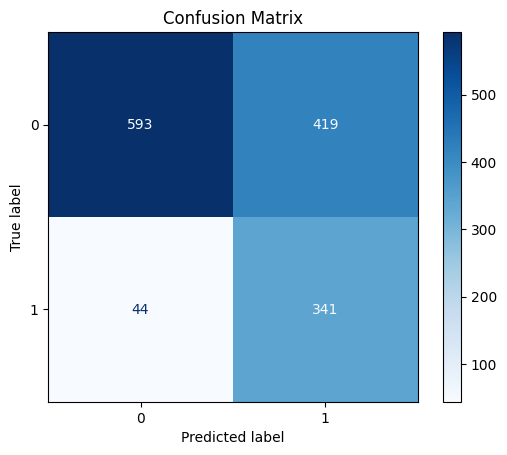

In [139]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

#### 1.3.4 ROC

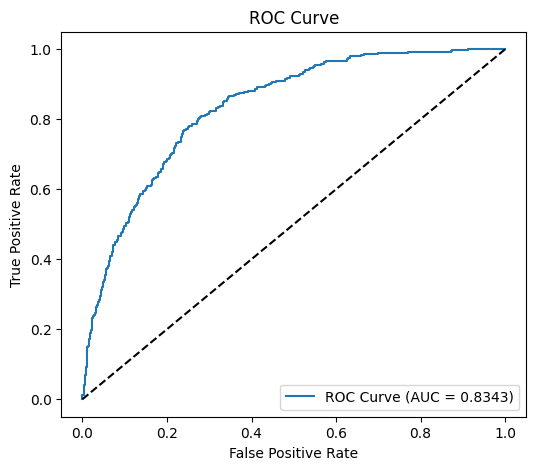

In [141]:
# --- ROC Curve ---
y_prob = model_lr.predict_proba(X_test)[:, 1]  # probabilities for ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## 2. Model Evaluation

### 2.1 KS Static

In [163]:
df_eval = pd.DataFrame({
    'Default Truth': y_test.values.flatten(),
    'Default Probability': y_prob.ravel()
})
df_eval.head(3)

,Default Truth,Default Probability
0,0,0.490152
1,0,0.463135
2,0,0.489663


In [165]:
df_eval['Decile'] = pd.qcut(df_eval['Default Probability'], 10, labels=False, duplicates='drop')

df_decile = df_eval.groupby('Decile').apply(lambda x: pd.Series({
    'Minimum Probability': x['Default Probability'].min(),
    'Maximum Probability': x['Default Probability'].max(),
    'Events': x['Default Truth'].sum(),
    'Non-events': x['Default Truth'].count() - x['Default Truth'].sum(),    
}))
df_decile.reset_index(inplace=True)
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events
0,0,0.450907,0.469706,3.0,137.0
1,1,0.469787,0.478898,1.0,139.0
2,2,0.478899,0.486688,9.0,130.0
3,3,0.486812,0.495095,20.0,120.0
4,4,0.495135,0.504765,17.0,123.0
5,5,0.504842,0.514807,35.0,104.0
6,6,0.514834,0.523035,56.0,84.0
7,7,0.523097,0.530338,60.0,79.0
8,8,0.530378,0.537788,80.0,60.0
9,9,0.537800,0.549687,104.0,36.0


In [166]:
df_eval[df_eval.Decile==8]['Default Probability'].describe()

count    140.000000
mean       0.533864
std        0.002273
min        0.530378
25%        0.531698
50%        0.533584
75%        0.535700
max        0.537788
Name: Default Probability, dtype: float64

In [167]:
df_decile['Event Rate'] = df_decile['Events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile['Non-event Rate'] = df_decile['Non-events']*100 / (df_decile['Events']+df_decile['Non-events'])
df_decile = df_decile.sort_values(by='Decile', ascending=False).reset_index(drop=True)
df_decile['Cum Events'] =  df_decile['Events'].cumsum()
df_decile['Cum Non-events'] =  df_decile['Non-events'].cumsum()
df_decile['Cum Event Rate'] = df_decile['Cum Events'] * 100 / df_decile['Events'].sum()
df_decile['Cum Non-event Rate'] = df_decile['Cum Non-events']*100 / df_decile['Non-events'].sum()
df_decile['KS'] = abs(df_decile['Cum Event Rate'] - df_decile['Cum Non-event Rate'])
df_decile

,Decile,Minimum Probability,Maximum Probability,Events,Non-events,Event Rate,Non-event Rate,Cum Events,Cum Non-events,Cum Event Rate,Cum Non-event Rate,KS
0,9,0.537800,0.549687,104.0,36.0,74.285714,25.714286,104.0,36.0,27.012987,3.557312,23.455675
1,8,0.530378,0.537788,80.0,60.0,57.142857,42.857143,184.0,96.0,47.792208,9.486166,38.306042
2,7,0.523097,0.530338,60.0,79.0,43.165468,56.834532,244.0,175.0,63.376623,17.292490,46.084133
3,6,0.514834,0.523035,56.0,84.0,40.000000,60.000000,300.0,259.0,77.922078,25.592885,52.329193
4,5,0.504842,0.514807,35.0,104.0,25.179856,74.820144,335.0,363.0,87.012987,35.869565,51.143422
5,4,0.495135,0.504765,17.0,123.0,12.142857,87.857143,352.0,486.0,91.428571,48.023715,43.404856
6,3,0.486812,0.495095,20.0,120.0,14.285714,85.714286,372.0,606.0,96.623377,59.881423,36.741954
7,2,0.478899,0.486688,9.0,130.0,6.474820,93.525180,381.0,736.0,98.961039,72.727273,26.233766
8,1,0.469787,0.478898,1.0,139.0,0.714286,99.285714,382.0,875.0,99.220779,86.462451,12.758329
9,0,0.450907,0.469706,3.0,137.0,2.142857,97.857143,385.0,1012.0,100.000000,100.000000,0.000000


**Insights**
- ***Strong Model Performance:** KS peaks at **52.33% (decile 6)** → excellent separation between churners and non-churners.*
- ***Top Churners Identified:** Top 3 deciles (9, 8, 7) capture majority of churners with high event rates (74%, 57%, 43%).*
- ***Low-risk Customers:** Bottom deciles (0, 1) have <3% event rate → minimal risk, can ignore in campaigns.* 
- ***Optimal Threshold:** Probability around **0.515–0.523** (decile 6) maximizes churner capture (~78%) while limiting non-churn inclusion (~26%).*

### Feature Importance

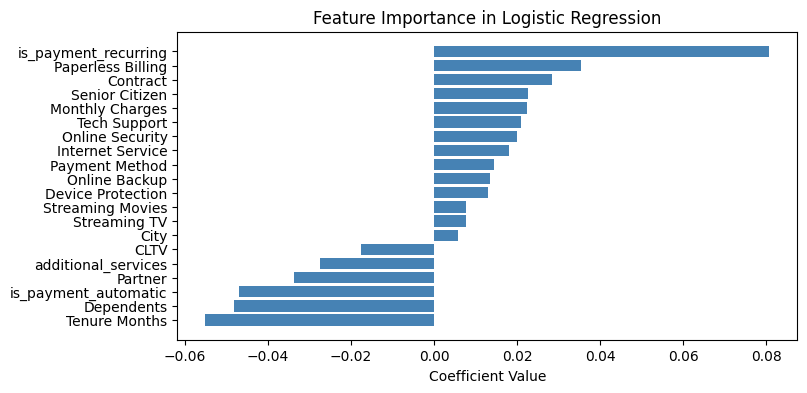

In [161]:
feature_importance = model_lr.coef_[0]

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train_resampled.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.show()

## 3. Export Model

In [ ]:
joblib.dump(model_lr, "artifacts/model_training/best_model.joblib")

['artifacts/model_training/best_model.joblib']